Low Light Image Enhancement with CNN

Group Members : Abhishek Maurya (2019uee0134) , Saurabh Kumar Verma (2019uch0033) , Balwant Yadav (2019uch0009) , Anshul Sharma (2019ucs0074)

In [27]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2 as cv
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input,decode_predictions
from keras import backend as K
from keras.layers import add, Conv2D,MaxPooling2D,UpSampling2D,Input,BatchNormalization, RepeatVector, Reshape, concatenate
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import set_random_seed
set_random_seed(2)
np.random.seed(1)
print(os.listdir("/content/drive/MyDrive/input"))

['Train', 'validation', 'test']


In [6]:
Image_input_path="/content/drive/MyDrive/input/Train/"

In [7]:
def noisy(img_noise_type,image):
    if img_noise_type == "gauss":
        row,col,ch= image.shape
        mean = 0
        var = 0.0001
        sigma = var**0.05
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        noisyImage =  gauss + image
        return noisyImage
    elif img_noise_type == "s&p":
        row,col,ch = image.shape
        s_vs_p = 0.5
        amount = 1.0
        outImage = np.copy(image)

        # Salt mode
        num_salt = np.ceil(image.size * s_vs_p)
        coords = [np.random.randint(0, i, int(num_salt))
              for i in image.shape]
        outImage[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i , int(num_pepper))
              for i in image.shape]
        outImage[coords] = 1
        return outImage

255

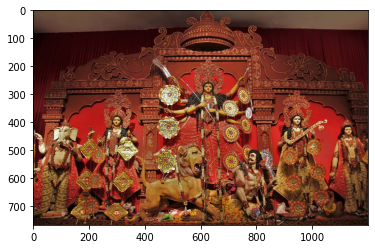

In [8]:
image = cv.imread(Image_input_path+"0 (3).jpg")  
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
l = image.max()
plt.imshow(image)
l


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


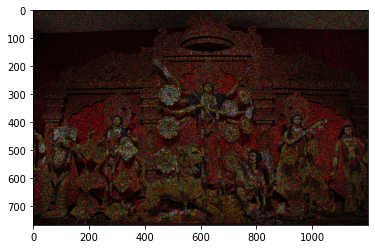

In [9]:
NoisyImage = noisy("s&p",image)
plt.imshow(NoisyImage)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


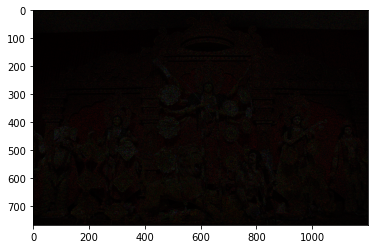

In [10]:
image_hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV) 
image_hsv[...,2] = image_hsv[...,2]*0.2
img1 = cv.cvtColor(image_hsv, cv.COLOR_HSV2BGR)
NoisyImage2 = noisy("s&p",img1)

plt.imshow(NoisyImage2)

In [20]:
def PreProcessData(Image_input_Path):
    X_=[]
    Y_=[]
    count=0
    for imageDir in os.listdir(Image_input_Path):
        if count<2131:
            try:
                count=count+1
                image = cv.imread(Image_input_Path + imageDir)
                image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
                image_y = cv.resize(image,(500,500))
                image_hsv = cv.cvtColor(image_y, cv.COLOR_BGR2HSV) #convert it to hsv
                image_hsv[...,2] = image_hsv[...,2]*0.2
                img_1 = cv.cvtColor(image_hsv, cv.COLOR_HSV2BGR)
                Noisy_image = noisy("s&p",img_1)
                X_.append(Noisy_image)
                Y_.append(image_y)
            except:
                pass
    X_ = np.array(X_)
    Y_ = np.array(Y_)
    
    return X_,Y_

In [21]:
X_,Y_ = PreProcessData(Image_input_path)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [22]:
K.clear_session()
def InstantiateModel(in_):
    
    model_1 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(in_)
    model_1 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_1)
    model_1 = Conv2D(64,(2,2), activation='relu',padding='same',strides=1)(model_1)
    
    model_2 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(in_)
    model_2 = Conv2D(64,(2,2), activation='relu',padding='same',strides=1)(model_2)
    
    model_2_0 = Conv2D(64,(2,2), activation='relu',padding='same',strides=1)(model_2)
    
    model_add = add([model_1,model_2,model_2_0])
    
    model_3 = Conv2D(64,(3,3), activation='relu',padding='same',strides=1)(model_add)
    model_3 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_3)
    model_3 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_3)
    
    model_3_1 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_add)
    model_3_1 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_3_1)
    
    model_3_2 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_add)
    
    model_add_2 = add([model_3_1,model_3_2,model_3])
    
    model_4 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(model_add_2)
    model_4_1 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(model_add)
    #Extension
    model_add_3 = add([model_4_1,model_add_2,model_4])
    
    model_5 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(model_add_3)
    model_5 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_add_3)
    
    model_5 = Conv2D(3,(3,3), activation='relu',padding='same',strides=1)(model_5)
    
    return model_5

In [23]:
Input_Sample = Input(shape=(500, 500,3))
Output_ = InstantiateModel(Input_Sample)
Model_Enhancer = Model(inputs=Input_Sample, outputs=Output_)

In [24]:
Model_Enhancer.compile(optimizer="adam", loss='mean_squared_error')
Model_Enhancer.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 500, 500, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 500, 500, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_3 (Conv2D)              (None, 500, 500, 32  896         ['input_1[0][0]']                
                                )                                                             

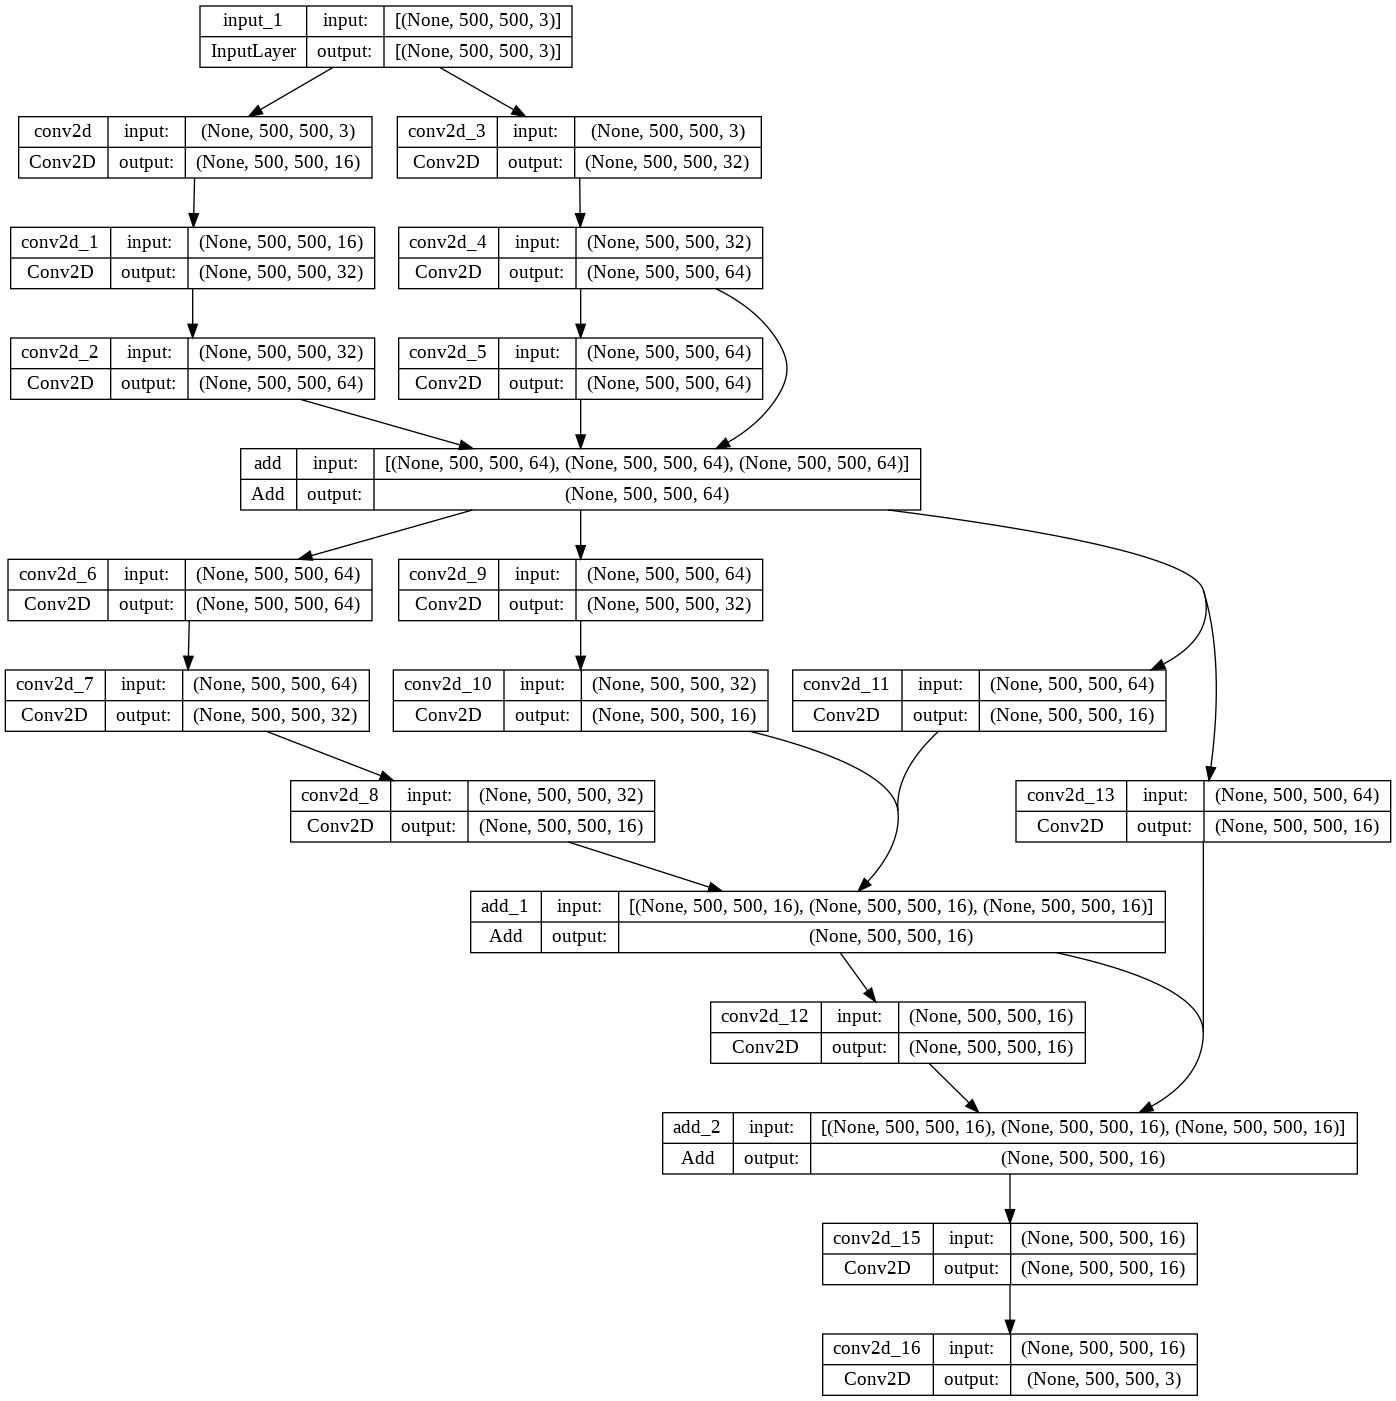

In [25]:
from keras.utils.vis_utils import plot_model
plot_model(Model_Enhancer,to_file='model_.png',show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image(retina=True, filename='model_.png')

In [26]:
def GenerateInputs(X,Y):
    for i in range(len(X)):
        X_input = X[i].reshape(1,500,500,3)
        Y_input = Y[i].reshape(1,500,500,3)
        yield (X_input,Y_input)
Model_Enhancer.fit_generator(GenerateInputs(X_,Y_),epochs=50,verbose=1,steps_per_epoch=40,shuffle=True)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


40/40 [==============================] - 218s 5s/step - loss: 8747.7051
Epoch 2/50
40/40 [==============================] - 211s 5s/step - loss: 2106.1179
Epoch 3/50
40/40 [==============================] - 211s 5s/step - loss: 1410.7424
Epoch 4/50
40/40 [==============================] - 212s 5s/step - loss: 1288.0530
Epoch 5/50
40/40 [==============================] - 214s 5s/step - loss: 991.5004
Epoch 6/50
40/40 [==============================] - 212s 5s/step - loss: 900.9071
Epoch 7/50
40/40 [==============================] - 210s 5s/step - loss: 729.4261
Epoch 8/50
40/40 [==============================] - 213s 5s/step - loss: 836.0897
Epoch 9/50
40/40 [==============================] - 225s 6s/step - loss: 690.0963
Epoch 10/50
40/40 [==============================] - 229s 6s/step - loss: 562.7410
Epoch 11/50
40/40 [==============================] - 335s 8s/step - loss: 602.3333
Epoch 12/50
40/40 [==============================] - 241s 6s/step - loss: 551.8613
Epoch 13/50
40/40 [=

In [85]:
Image_test_path="/content/drive/MyDrive/input/Train/"

In [60]:
def extract_test_image(ImagePath):
    image = cv.imread(ImagePath)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image_ = cv.resize(image,(500,500))
    img_hsv = cv.cvtColor(image_, cv.COLOR_BGR2HSV) #convert it to hsv
    img_hsv[...,2] = img_hsv[...,2]*0.2
    image1 = cv.cvtColor(img_hsv, cv.COLOR_HSV2BGR)
    Noisy_img = noisy("s&p",image1)
    Noisy_img = Noisy_img.reshape(1,500,500,3)
    return Noisy_img

In [86]:
Test_image_path=Image_test_path+"101 (6).jpg"
image_for_test = extract_test_image(Test_image_path)
Prediction = Model_Enhancer.predict(image_for_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


1/1 [==============================] - 1s 1s/step


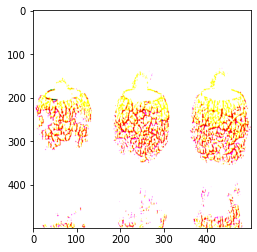

In [87]:
Prediction = Prediction.reshape(500,500,3)
plt.imshow(Prediction)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


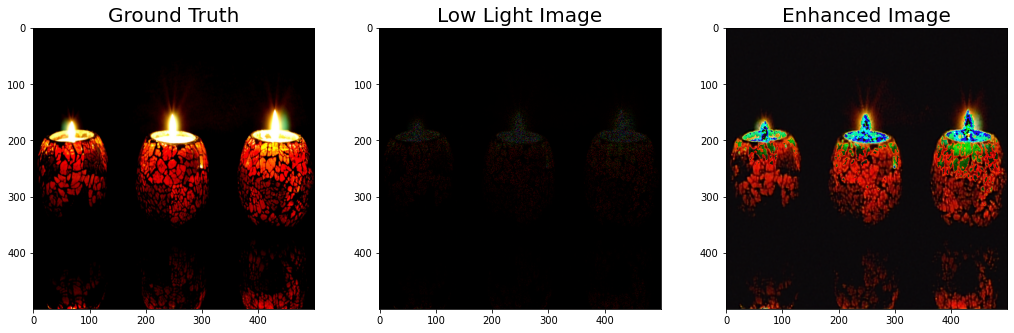

In [90]:
Test_image=Image_test_path+"101 (6).jpg"
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
image_1 = cv.imread(Test_image)
image_1 = cv.cvtColor(image_1, cv.COLOR_BGR2RGB)
image_1 = cv.resize(image_1, (500, 500))
plt.title("Ground Truth",fontsize=20)
plt.imshow(image_1)

plt.subplot(5,5,1+1)
image_ = extract_test_image(Test_image)
image_ = image_.reshape(500,500,3)
plt.title("Low Light Image",fontsize=20)
plt.imshow(image_)

plt.subplot(5,5,1+2)
image_[:,:,:] = Prediction[:,:,:]
plt.title("Enhanced Image",fontsize=20)
plt.imshow(image_)

In [91]:
Image_test_path2="/content/drive/MyDrive/input/validation/validation/travel and adventure/"

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


1/1 [==============================] - 1s 1s/step


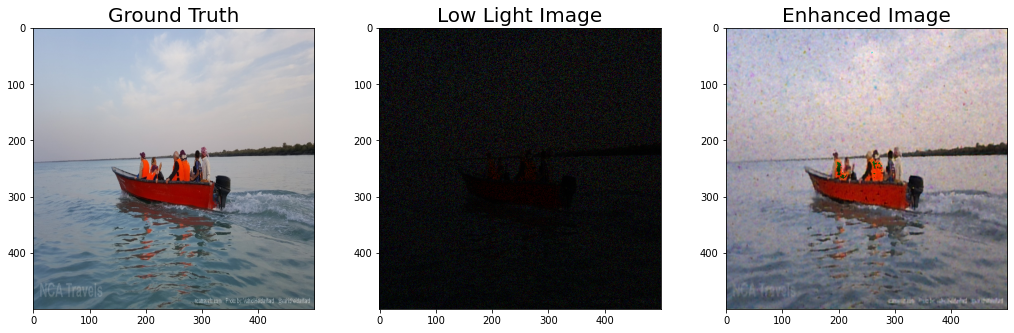

In [92]:
Test_image2=Image_test_path2+"0.jpg"
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
image_1 = cv.imread(Test_image2)
image_1 = cv.cvtColor(image_1, cv.COLOR_BGR2RGB)
image_1 = cv.resize(image_1, (500, 500))
plt.title("Ground Truth",fontsize=20)
plt.imshow(image_1)

plt.subplot(5,5,1+1)
image_ = extract_test_image(Test_image2)
Prediction = Model_Enhancer.predict(image_)
image_ = image_.reshape(500,500,3)
plt.title("Low Light Image",fontsize=20)
plt.imshow(image_)

plt.subplot(5,5,1+2)
Prediction = Prediction.reshape(500,500,3)
image_[:,:,:] = Prediction[:,:,:]
plt.title("Enhanced Image",fontsize=20)
plt.imshow(image_)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


1/1 [==============================] - 1s 1s/step


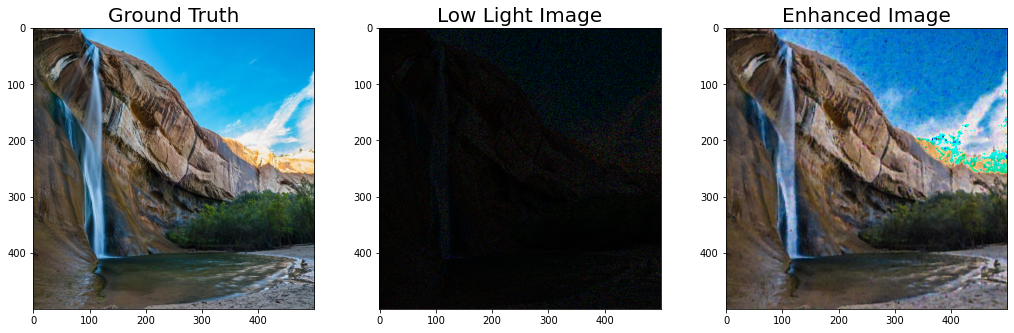

In [93]:
Test_image2=Image_test_path2+"13.jpg"
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
image_1 = cv.imread(Test_image2)
image_1 = cv.cvtColor(image_1, cv.COLOR_BGR2RGB)
image_1 = cv.resize(image_1, (500, 500))
plt.title("Ground Truth",fontsize=20)
plt.imshow(image_1)

plt.subplot(5,5,1+1)
image_ = extract_test_image(Test_image2)
Prediction = Model_Enhancer.predict(image_)
image_ = image_.reshape(500,500,3)
plt.title("Low Light Image",fontsize=20)
plt.imshow(image_)

plt.subplot(5,5,1+2)
Prediction = Prediction.reshape(500,500,3)
image_[:,:,:] = Prediction[:,:,:]
plt.title("Enhanced Image",fontsize=20)
plt.imshow(image_)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


1/1 [==============================] - 1s 1s/step


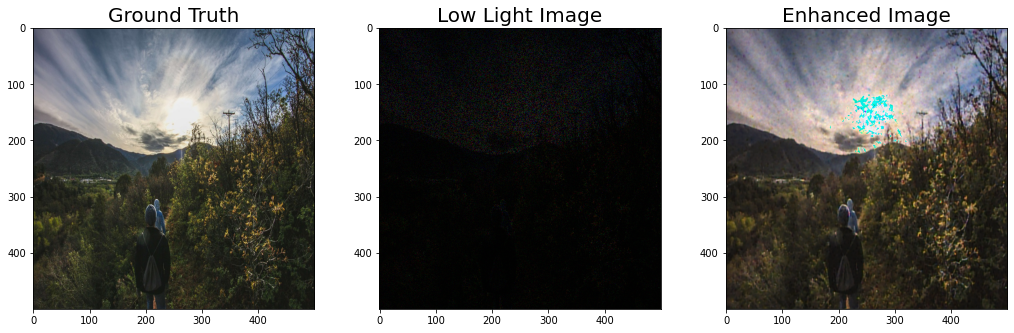

In [94]:
Test_image2=Image_test_path2+"18.jpg"
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
image_1 = cv.imread(Test_image2)
image_1 = cv.cvtColor(image_1, cv.COLOR_BGR2RGB)
image_1 = cv.resize(image_1, (500, 500))
plt.title("Ground Truth",fontsize=20)
plt.imshow(image_1)

plt.subplot(5,5,1+1)
image_ = extract_test_image(Test_image2)
Prediction = Model_Enhancer.predict(image_)
image_ = image_.reshape(500,500,3)
plt.title("Low Light Image",fontsize=20)
plt.imshow(image_)

plt.subplot(5,5,1+2)
Prediction = Prediction.reshape(500,500,3)
image_[:,:,:] = Prediction[:,:,:]
plt.title("Enhanced Image",fontsize=20)
plt.imshow(image_)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


1/1 [==============================] - 1s 1s/step


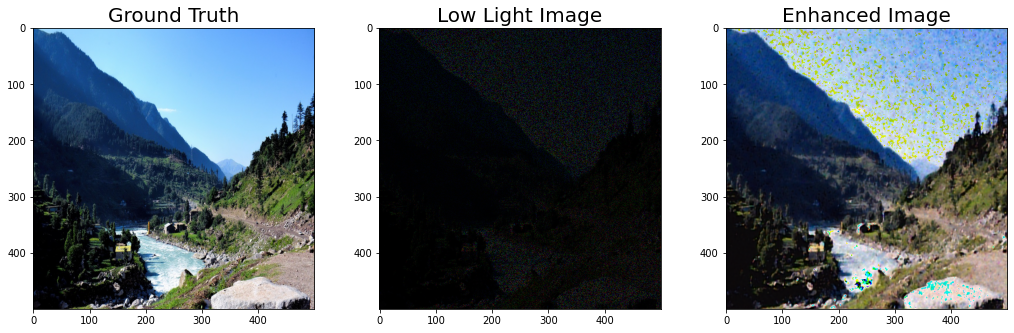

In [95]:
Test_image2=Image_test_path2+"2.jpg"
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
image_1 = cv.imread(Test_image2)
image_1 = cv.cvtColor(image_1, cv.COLOR_BGR2RGB)
image_1 = cv.resize(image_1, (500, 500))
plt.title("Ground Truth",fontsize=20)
plt.imshow(image_1)

plt.subplot(5,5,1+1)
image_ = extract_test_image(Test_image2)
Prediction = Model_Enhancer.predict(image_)
image_ = image_.reshape(500,500,3)
plt.title("Low Light Image",fontsize=20)
plt.imshow(image_)

plt.subplot(5,5,1+2)
Prediction = Prediction.reshape(500,500,3)
image_[:,:,:] = Prediction[:,:,:]
plt.title("Enhanced Image",fontsize=20)
plt.imshow(image_)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


1/1 [==============================] - 1s 1s/step


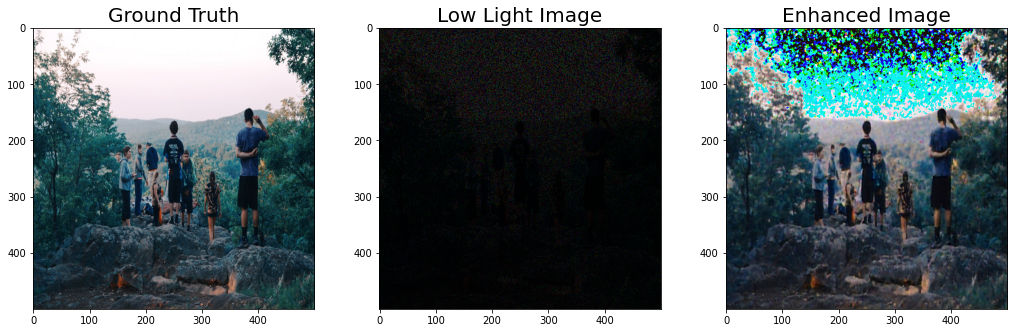

In [96]:
Test_image2=Image_test_path2+"14.jpg"
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
image_1 = cv.imread(Test_image2)
image_1 = cv.cvtColor(image_1, cv.COLOR_BGR2RGB)
image_1 = cv.resize(image_1, (500, 500))
plt.title("Ground Truth",fontsize=20)
plt.imshow(image_1)

plt.subplot(5,5,1+1)
image_ = extract_test_image(Test_image2)
Prediction = Model_Enhancer.predict(image_)
image_ = image_.reshape(500,500,3)
plt.title("Low Light Image",fontsize=20)
plt.imshow(image_)

plt.subplot(5,5,1+2)
Prediction = Prediction.reshape(500,500,3)
image_[:,:,:] = Prediction[:,:,:]
plt.title("Enhanced Image",fontsize=20)
plt.imshow(image_)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


1/1 [==============================] - 1s 1s/step


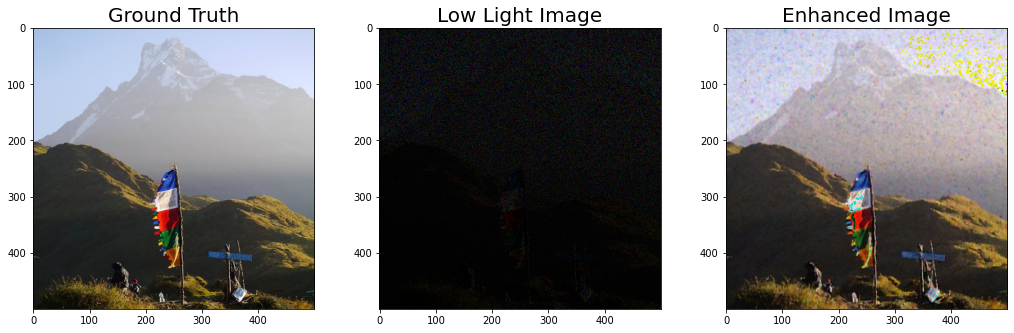

In [97]:
Test_image2=Image_test_path2+"11.jpg"
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
image_1 = cv.imread(Test_image2)
image_1 = cv.cvtColor(image_1, cv.COLOR_BGR2RGB)
image_1 = cv.resize(image_1, (500, 500))
plt.title("Ground Truth",fontsize=20)
plt.imshow(image_1)

plt.subplot(5,5,1+1)
image_ = extract_test_image(Test_image2)
Prediction = Model_Enhancer.predict(image_)
image_ = image_.reshape(500,500,3)
plt.title("Low Light Image",fontsize=20)
plt.imshow(image_)

plt.subplot(5,5,1+2)
Prediction = Prediction.reshape(500,500,3)
image_[:,:,:] = Prediction[:,:,:]
plt.title("Enhanced Image",fontsize=20)
plt.imshow(image_)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


1/1 [==============================] - 1s 1s/step


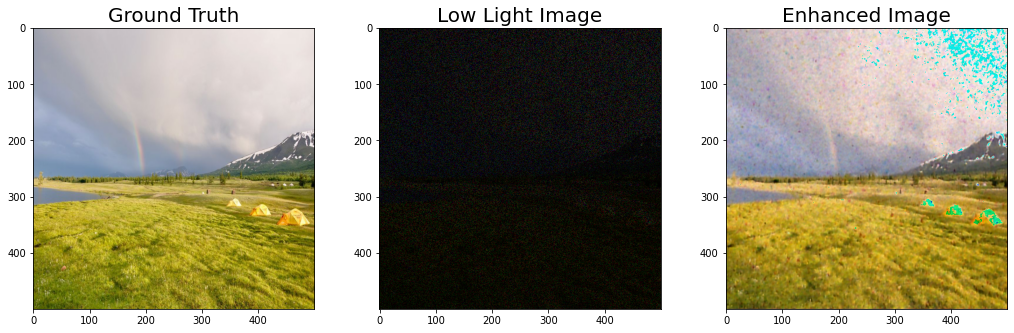

In [98]:
Test_image2=Image_test_path2+"10.jpg"
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
image_1 = cv.imread(Test_image2)
image_1 = cv.cvtColor(image_1, cv.COLOR_BGR2RGB)
image_1 = cv.resize(image_1, (500, 500))
plt.title("Ground Truth",fontsize=20)
plt.imshow(image_1)

plt.subplot(5,5,1+1)
image_ = extract_test_image(Test_image2)
Prediction = Model_Enhancer.predict(image_)
image_ = image_.reshape(500,500,3)
plt.title("Low Light Image",fontsize=20)
plt.imshow(image_)

plt.subplot(5,5,1+2)
Prediction = Prediction.reshape(500,500,3)
image_[:,:,:] = Prediction[:,:,:]
plt.title("Enhanced Image",fontsize=20)
plt.imshow(image_)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


1/1 [==============================] - 1s 1s/step


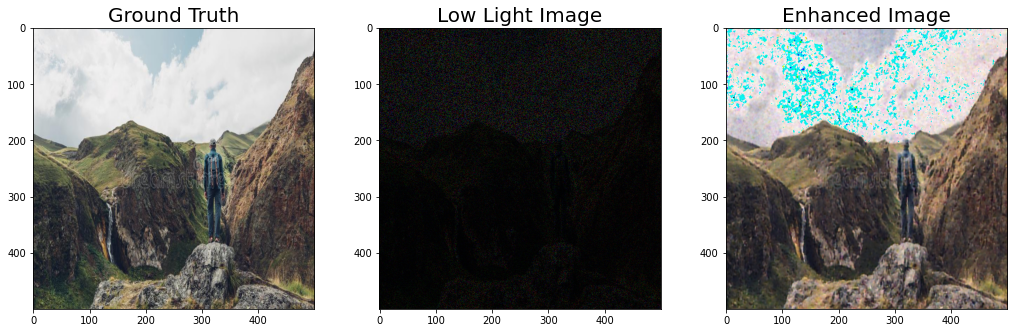

In [99]:
Test_image2=Image_test_path2+"12.jpg"
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
image_1 = cv.imread(Test_image2)
image_1 = cv.cvtColor(image_1, cv.COLOR_BGR2RGB)
image_1 = cv.resize(image_1, (500, 500))
plt.title("Ground Truth",fontsize=20)
plt.imshow(image_1)

plt.subplot(5,5,1+1)
image_ = extract_test_image(Test_image2)
Prediction = Model_Enhancer.predict(image_)
image_ = image_.reshape(500,500,3)
plt.title("Low Light Image",fontsize=20)
plt.imshow(image_)

plt.subplot(5,5,1+2)
Prediction = Prediction.reshape(500,500,3)
image_[:,:,:] = Prediction[:,:,:]
plt.title("Enhanced Image",fontsize=20)
plt.imshow(image_)